This notebook demonstrates the capability of I-PINN for the problem of a sphere inside a unit cube. The sphere is characterized by a constant permeability of 1, while the surrounding cube features a variable permeability denoted by μ. 
The problem is a 5D problem (3D, transient, and parametric)
By leveraging the capabilities of I-PINNs, this project aims to accurately model and predict the electromagnetic behavior with no external data.

In [1]:
import numpy as np
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.jit import script, trace
import matplotlib.pyplot as plt

Below are necessary functions to calculate the residuals of the equations. The equations used are the first-order Maxwell's equations. The permeability in the domain is expressed as 
 $$\mu = x_4 \cdot \hat{H} + 1$$
 where
- $x_4$ is a parameter.
- $\hat{H}$ denotes the Heaviside function on the interface.

In [3]:
def get_derivH(H,Y):

    gH=torch.autograd.grad(H,Y,grad_outputs=torch.ones_like(H),retain_graph=True,create_graph=True, allow_unused=True)[0]
    H_x=gH[:,0:1]
    H_y=gH[:,1:2]
    H_z=gH[:,2:3]
    H_t=gH[:,3:4]

    return H_x , H_y, H_z, H_t

def T_curl(Hx,Hy,Hz,Y):
    Hx_x , Hx_y, Hx_z, Hx_t = get_derivH(Hx,Y)
    Hy_x , Hy_y, Hy_z, Hy_t = get_derivH(Hy,Y)
    Hz_x , Hz_y, Hz_z, Hz_t = get_derivH(Hz,Y)

    #E=curl(V[0-->2])
    c1=(Hz_y-Hy_z)
    c2=(Hx_z-Hz_x)
    c3=(Hy_x-Hx_y)
    div=Hx_x + Hy_y + Hz_z
    return c1,c2,c3, Hx_t,Hy_t,Hz_t ,div

def equa_F(Hx,Hy,Hz,Ex,Ey,Ez,Y,rho,mu,Fx,Fy,Fz, tag):

    k=Y[:,4:5]

    r=torch.sqrt((0.5-Y[:,0:1])**2 + (0.5-Y[:,1:2])**2 + (0.5-Y[:,2:3])**2 )
    mu=k*torch.sigmoid(100*(r-0.25)) + 1

    rho=1

    cH1,cH2,cH3, Hx_t, Hy_t, Hz_t,div = T_curl(Hx,Hy,Hz,Y)
    cE1,cE2,cE3, Ex_t, Ey_t, Ez_t,divE = T_curl(Ex,Ey,Ez,Y)

    resx=mu*Hx_t + 1*cE1 
    resy=mu*Hy_t + 1*cE2 
    resz=mu*Hz_t + 1*cE3 

    res2x=Ex*1/rho-cH1
    res2y=Ey*1/rho-cH2
    res2z=Ez*1/rho-cH3 

    return resx,resy,resz, res2x,res2y,res2z,div,divE



Below is the I-PINN neural network

In [5]:

#weigh initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        #m.bias.data.fill_(0.01)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#neural network architecture
class NetF(nn.Module):
    def __init__(self):
        super().__init__()
        n=50

        self.base = nn.Sequential(
          nn.Linear(11,n),
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,n),

        )
        self.head1 =  nn.Sequential(
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,1)
        )

        self.head2 =  nn.Sequential(
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,1)
        )

        self.head3 =  nn.Sequential(
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,1)
        )

        self.head4 =  nn.Sequential(
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,1)
        )
        self.head5 =  nn.Sequential(
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,1)
        )
        self.head6 =  nn.Sequential(
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,1)
        )
    def forward(self, x):

        #in I-PINN, we augment the input vector with function containing high frequencies at the interface,
        # and with a vector field normal to the interface
        
        r=torch.sqrt((0.5-x[:,0:1])**2 + (0.5-x[:,1:2])**2 + (0.5-x[:,2:3])**2 ) 
        
        #the high-frequency functions
        
        mu=torch.sigmoid(50*(0.2-r))
        mu1=torch.sigmoid(50*(0.2-r))
        mu2=torch.sigmoid(100*(0.2-r))
        
        #the normal vector field
        mux,muy,muz,mut=get_derivH(mu,x)
        mod= 50*0.25
        
        #the augmented input vector
        Xa=torch.column_stack((x,mu,mux/mod,muy/mod,muz/mod ,mu1,mu2))
        
        #Forward pass
        x1 = self.base(Xa)
        x2=self.head1(x1) 
        x3=self.head2(x1) 
        x4=self.head3(x1) 
        x5=self.head4(x1) 
        x6=self.head5(x1) 
        x7=self.head6(x1) 

        return x2 ,x3 ,x4 ,x5,x6 ,x7


netF = NetF()
netF.apply(init_weights)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
netF=netF.to(device)

The function below is used to strongly impose the boundary conditions. We impose a dirichlet boundary conditions $H = [0,0,t]$ on the 4 sides of the cube, and $E=[0,0,0]$ on the top and bottom of the cube. The initial condition in zero.

In [20]:
def for_pass_F(X):
    Bx,By,Bz,Dx,Dy,Dz=netF(X)
    w1=X[:,0:1]
    w2=X[:,1:2]
    w3=1-w1
    w4=1-w2
    hb = X[:,2:3]
    ht = 1-hb
    t=X[:,3:4]

    d1= 1-torch.exp(-w1*20)
    d2= 1-torch.exp(-w2*20)
    d3= 1-torch.exp(-w3*20)
    d4= 1-torch.exp(-w4*20)
    d5= 1-torch.exp(-hb*20)
    d6= 1-torch.exp(-ht*20)
    dt= 1-torch.exp(-t*20)


    Hx = Bx*d2*d4*d5*d6*dt
    Hy = By*d1*d3*d5*d6*dt
    Hz = Bz *d1*d2*d3*d4*dt + 1*t

    Ex = Dx*d1*d3
    Ey = Dy*d2*d4
    Ez = Dz*d5*d6


    return Hx,Hy,Hz,Ex,Ey,Ez






In [7]:
L=[]

This function creates N random points inside the computational domain

In [13]:
def get_x(N):
  X=np.random.uniform(0,1,(N,5))
  X[:,4:5]= np.random.uniform(-0.6,0.6,(N,1))
  X=torch.tensor(X).float()
  return X

In [14]:
#this function plots the results Hz(x=0.5, y=0.5, z, mu=1.5) 
def plot_results():

    Xt= get_x(5000,1).detach().to(device)
    Xt[:,0]=0.5
    Xt[:,1]=0.5
    Xt[:,3]=1
    rho=0.5 
    Xt[:,4:5]=rho
    
    
    Xt.requires_grad=True
    
    vx=0
    vy=0 
    vz=0


    Hx,Hy,Hz,Dx,Dy,Dz = for_pass_F(Xt)

    plt.plot(Xt[:,2].detach().cpu(),Hz.detach().cpu(),'*')


    plt.pause(0.005)


The function below introduce additional collocation points in critical parts of the domain. It creates a N random points in the computational domain, and keeps the n points with the highest residual. These 200 points are concatenated with the original collocation points.

In [17]:
def remesh(X0,N,n):
  X=get_x(N)
  X.requires_grad=True
  X = X.to(device)
  Rm=1

  r=torch.sqrt((0.5-X[:,0:1])**2 + (0.5-X[:,1:2])**2 + (0.5-X[:,2:3])**2 )
  mu=X[:,3:4]*torch.sigmoid(500*(r-0.2)) + 1

  vx=0
  vy=0
  vz=0
  Hx,Hy,Hz,Dx,Dy,Dz = for_pass_F(X)

  tag=0
  resx,resy,resz, res2x,res2y,res2z,div,divE = equa_F(Hx,Hy,Hz,Dx,Dy,Dz,X,1,mu,0,0,0,tag)
  cH1,cH2,cH3,h1t,h2t,h3t,divH = T_curl(mu*Hx,mu*Hy,mu*Hz,X)

  V= resx**2+resy**2+resz**2+ res2x**2+res2y**2+res2z**2+divH**2+divE**2


  nmax=torch.topk(V.reshape(-1), n).indices
  Xout=torch.concatenate((X0,X.detach()[nmax,:]) )
  return Xout

In [19]:
X= get_x(60000)#.to(device)
X=X.to(device)
X=remesh(X,200000,20000)


In [ ]:
X.shape

In [160]:

X.requires_grad=True
X = X.to(device)

In [21]:
def closure():

#calculating mu
  r=torch.sqrt((0.5-X[:,0:1])**2 + (0.5-X[:,1:2])**2 + (0.5-X[:,2:3])**2 )
  a=500
  mu=X[:,4:5]*torch.sigmoid(a*(r-0.2)) + 1
    
#calculating the electromagnetic field
  Hx,Hy,Hz,Dx,Dy,Dz = for_pass_F(X)

#calculating the residual
  tag=0
  resx,resy,resz, res2x,res2y,res2z,div,divE = equa_F(Hx,Hy,Hz,Dx,Dy,Dz,X,1,mu,0,0,0,tag)
  cH1,cH2,cH3, Hx_t,Hy_t,Hz_t ,divH = T_curl(mu*Hx,mu*Hy,mu*Hz,X)

#the loss function
  loss1=1*criterion(resx*T,resx*0) + 1*criterion(resy*T,resy*0) + 1*criterion(resz*T,resz*0) + 1*criterion(divH*T,divH*0)
  loss2=1*criterion(res2x*T,res2x*0) + 1*criterion(res2y*T,res2y*0) + 1*criterion(res2z*T,res2z*0) + 1*criterion(divE*T,divE*0)
  loss=1*loss1 + 1*loss2
  optimizer.zero_grad()

  L.append(loss.detach().cpu().numpy())

  loss.backward()
  return loss


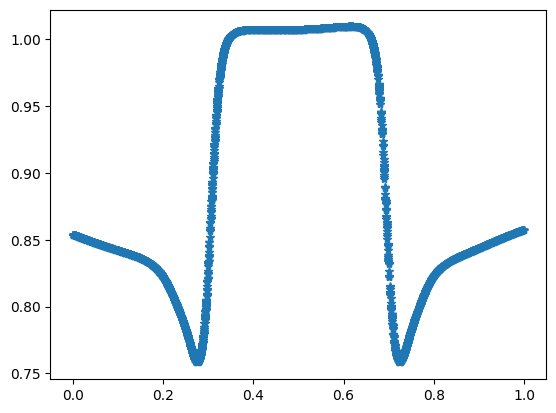

tensor(0.0050, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0046, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0043, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0041, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0039, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0037, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<MulBackward0>)


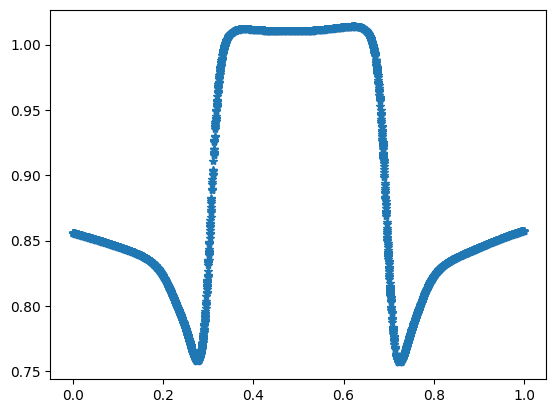

tensor(0.0028, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)


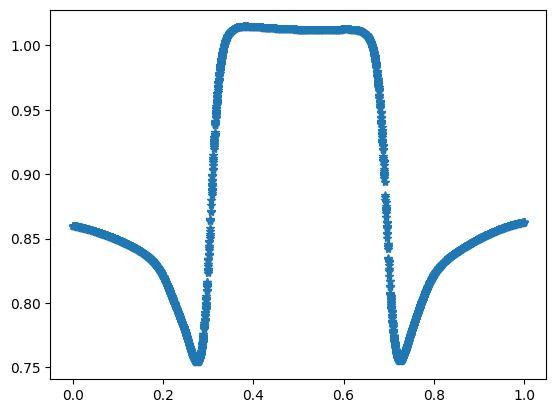

tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<MulBackward0>)


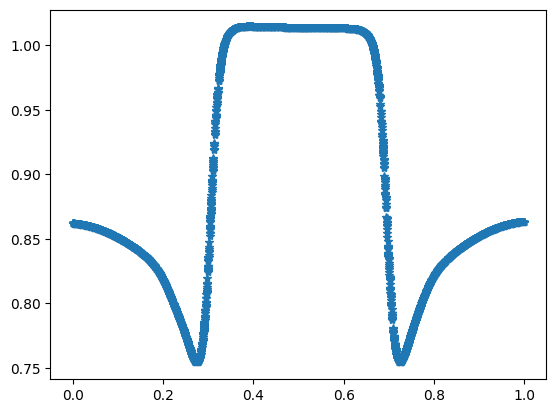

tensor(0.0015, device='cuda:0', grad_fn=<MulBackward0>)


KeyboardInterrupt: 

In [163]:
learning_rate=1*1*10**-4
learning_rate2=1
criterion = nn.MSELoss()
optimizer = optim.Adam(netF.parameters(), lr=learning_rate)#, weight_decay=0.01)
optimizer2 = optim.LBFGS(netF.parameters(), lr=learning_rate2)

T=1
#training with 5000 adams iterations and 4000 L-BFGS iterations 
for i in range(5000):
  loss=optimizer.step(closure)
  L.append(loss.detach().cpu().numpy())
  if (i%100 ==0):
    plot_results()
  if (i%10==0):
      print(loss*1)

for i in range(200):
  loss=optimizer2.step(closure)
  L.append(loss.detach().cpu().numpy())
  if (i%100 ==0):
    plot_results()
  if (i%10==0):
      print(loss*1)


We vizualize the results for Hz(0.5,0.5,z,0.5), and $\mu$ outside the sphere equal to $\mu=1+x4$

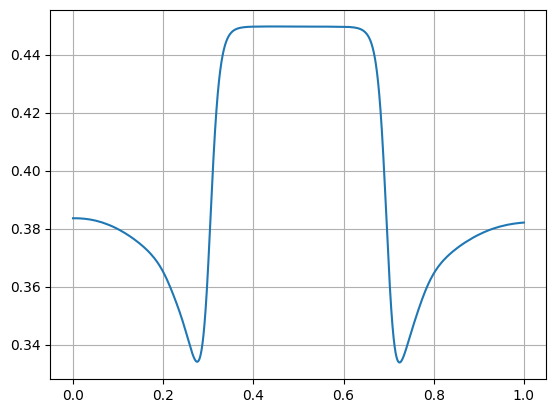

In [165]:

Xt= torch.zeros(10000,5).detach().to(device)
Xt[:,0]=0.5 #x
Xt[:,1]=0.5 #y
Xt[:,2]=torch.linspace(0,1,10000) #z
Xt[:,3]=0.5 #t
x4=0.5
Xt[:,4:5]=x4 # mu = 1 + x4


Xt.requires_grad=True

Hx,Hy,Hz,Dx,Dy,Dz = for_pass_F(Xt)


plt.plot(Xt[:,2].detach().cpu(),Hz.detach().cpu())
plt.grid()

plt.pause(0.005)

In [87]:
max(Hz)

tensor([0.6487], device='cuda:0', grad_fn=<UnbindBackward0>)

In [ ]:
from google.colab import files


In [ ]:
np.savetxt('pinn_mu(t=1,mu=05).csv', Hz.detach().cpu(), delimiter=',')
files.download('pinn_mu(t=1,mu=05).csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
max(Hz)

tensor([1.3039], device='cuda:0', grad_fn=<UnbindBackward0>)

In [ ]:
min(Hz)*1.5

tensor([1.1408], device='cuda:0', grad_fn=<MulBackward0>)